In [1]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint

from scipy.stats import skew, pearsonr

import warnings
warnings.filterwarnings('ignore')

In [2]:
# set random seed
seed_val = 1160
np.random.seed(seed_val)

# Targeted directory
target_fold_dir = 'fold1'

In [3]:
# import the given fold data
X_train_full = pd.read_csv(f'{target_fold_dir}/train.csv', index_col='PID')
X_train = X_train_full.iloc[:, :-1] # exclude the last two columns
y_train = np.log(X_train_full.iloc[:, -1])

# import the test data
X_test = pd.read_csv(f'{target_fold_dir}/test.csv', index_col='PID')
y_test = np.log(pd.read_csv(f'{target_fold_dir}/test_y.csv', index_col='PID').iloc[:, -1])


In [4]:
# inspect the data
display(X_train_full.head())
display(X_train.head())
display(X_test.head())
display(y_test.head())
display(y_train.head())

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude,Sale_Price
PID,,,,,,,,,,,,,,,,,,,,,
526350040,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,NaN,0,6,2010,WD,Normal,-93.619756,42.053014,105000
526351010,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,Gar2,12500,6,2010,WD,Normal,-93.619387,42.052659,172000
527105010,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Minimum_Privacy,NaN,0,3,2010,WD,Normal,-93.638933,42.060899,189900
527105030,Two_Story_1946_and_Newer,Residential_Low_Density,78,9978,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,No_Fence,NaN,0,6,2010,WD,Normal,-93.638925,42.060779,195500
527127150,One_Story_PUD_1946_and_Newer,Residential_Low_Density,41,4920,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Fence,NaN,0,4,2010,WD,Normal,-93.633792,42.062978,213500


,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude
PID,,,,,,,,,,,,,,,,,,,,,
526350040,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,NaN,0,6,2010,WD,Normal,-93.619756,42.053014
526351010,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,Gar2,12500,6,2010,WD,Normal,-93.619387,42.052659
527105010,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,NaN,0,3,2010,WD,Normal,-93.638933,42.060899
527105030,Two_Story_1946_and_Newer,Residential_Low_Density,78,9978,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,No_Pool,No_Fence,NaN,0,6,2010,WD,Normal,-93.638925,42.060779
527127150,One_Story_PUD_1946_and_Newer,Residential_Low_Density,41,4920,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,No_Fence,NaN,0,4,2010,WD,Normal,-93.633792,42.062978


,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude
PID,,,,,,,,,,,,,,,,,,,,,
908276150,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,0,8926,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,Minimum_Privacy,NaN,0,10,2009,COD,Abnorml,-93.663302,42.018592
903451090,Two_Story_1945_and_Older,Residential_Medium_Density,57,6876,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,NaN,0,8,2009,WD,Normal,-93.628299,42.025306
527110080,Two_Story_1946_and_Newer,Residential_Low_Density,0,13869,Pave,No_Alley_Access,Moderately_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,NaN,0,7,2007,WD,Normal,-93.636146,42.061664
535457010,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,87,10000,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,NaN,0,2,2010,WD,Normal,-93.605943,42.034748
903484020,One_and_Half_Story_Finished_All_Ages,Residential_Medium_Density,60,10320,Pave,Gravel,Regular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,NaN,0,6,2008,WD,Normal,-93.624580,42.023716


PID
908276150    11.626254
903451090    11.911702
527110080    12.083905
535457010    11.982929
903484020    11.813030
Name: Sale_Price, dtype: float64

PID
526350040    11.561716
526351010    12.055250
527105010    12.154253
527105030    12.183316
527127150    12.271392
Name: Sale_Price, dtype: float64

In [5]:
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()
y_train_processed = y_train.copy()
y_test_processed = y_test.copy()

In [6]:
def clean(df: pd.DataFrame) -> pd.DataFrame:
    max_year = 2011 # the max year of the training data
    # corrupted Garage_Yr_Blt = less than Year_Built or nan
    df['Garage_Yr_Blt'] = df['Garage_Yr_Blt'].apply(lambda x: x if x <= max_year else np.nan)
    df['Garage_Yr_Blt'] = df['Garage_Yr_Blt'].fillna(df['Year_Built'])
    return df

X_train_processed = clean(X_train_processed)
X_test_processed = clean(X_test_processed)

Drop 19 rows


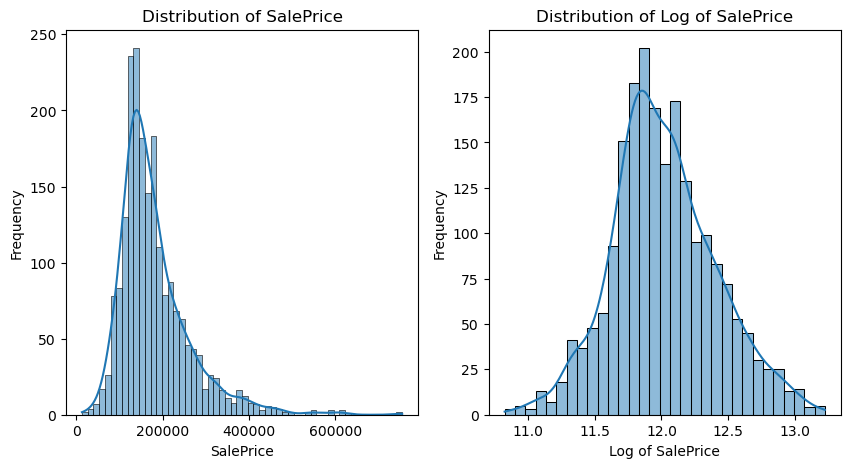

In [7]:
# plot the sales price distribution (original, log)
y_train_original = X_train_full.iloc[:, -1]

# drop the rows with extreme price larger
mean = y_train.mean()
std = y_train.std()    
rows_to_drop = y_train[(y_train > mean + 3 * std) | (y_train < mean - 3 * std)].index
print(f'Drop {len(rows_to_drop)} rows')
X_train_processed = X_train_processed.drop(index=rows_to_drop)
y_train_processed = y_train_processed.drop(index=rows_to_drop)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(y_train_original, kde=True, ax=axs[0]) 
axs[0].set_title('Distribution of SalePrice')
axs[0].set_xlabel('SalePrice')
axs[0].set_ylabel('Frequency')

sns.histplot(y_train_processed, kde=True, ax=axs[1]) 
axs[1].set_title('Distribution of Log of SalePrice')
axs[1].set_xlabel('Log of SalePrice')
axs[1].set_ylabel('Frequency')

plt.show()

In [8]:
def process_numeric_features(df: pd.DataFrame) -> tuple[pd.DataFrame, list]: 
    skew_threshold = 0.5
    
    #log transform skewed numeric features:
    numeric_feats = df.dtypes[df.dtypes != "object"].index

    skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > skew_threshold]
    skewed_feats = skewed_feats.index

    df[skewed_feats] = np.log1p(df[skewed_feats])
    print(f"Log transformed {len(skewed_feats)} skewed features")
    print(f"The skewed features are {skewed_feats}")
    return df, skewed_feats

X_train_processed, skewed_feats = process_numeric_features(X_train_processed)
X_test_processed[skewed_feats] = np.log1p(X_test_processed[skewed_feats])

Log transformed 21 skewed features
The skewed features are Index(['Lot_Area', 'Mas_Vnr_Area', 'BsmtFin_SF_2', 'Bsmt_Unf_SF',
       'First_Flr_SF', 'Second_Flr_SF', 'Low_Qual_Fin_SF', 'Gr_Liv_Area',
       'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Half_Bath', 'Kitchen_AbvGr',
       'TotRms_AbvGrd', 'Fireplaces', 'Wood_Deck_SF', 'Open_Porch_SF',
       'Enclosed_Porch', 'Three_season_porch', 'Screen_Porch', 'Pool_Area',
       'Misc_Val'],
      dtype='object')


#### Categorical features

<Axes: xlabel='None', ylabel='None'>

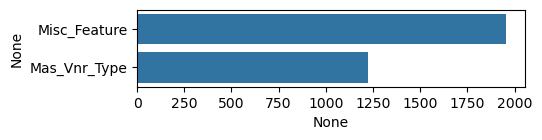

In [9]:
train_c = X_train_processed[[
    c for c in X_train_processed.columns if X_train_processed[c].dtypes == 'O']].copy()
test_c = X_test_processed[[
    c for c in X_test_processed.columns if X_test_processed[c].dtypes == 'O']].copy()

# print(train_c.shape)
fig = plt.figure(figsize=(5, 1))
train_null = train_c.isnull().sum()[train_c.isnull().sum() != 0].sort_values(ascending=False)
sns.barplot(y=train_null.index, x=train_null)

In [10]:
# dropping the rows with missing values in the categorical features
X_train_processed = X_train_processed.drop(columns=train_null.index)
X_test_processed = X_test_processed.drop(columns=train_null.index)
print(X_train_processed.columns)

Index(['MS_SubClass', 'MS_Zoning', 'Lot_Frontage', 'Lot_Area', 'Street',
       'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities', 'Lot_Config',
       'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
       'House_Style', 'Overall_Qual', 'Overall_Cond', 'Year_Built',
       'Year_Remod_Add', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
       'Exterior_2nd', 'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond',
       'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2', 'BsmtFin_SF_2',
       'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating', 'Heating_QC', 'Central_Air',
       'Electrical', 'First_Flr_SF', 'Second_Flr_SF', 'Low_Qual_Fin_SF',
       'Gr_Liv_Area', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath',
       'Half_Bath', 'Bedroom_AbvGr', 'Kitchen_AbvGr', 'Kitchen_Qual',
       'TotRms_AbvGrd', 'Functional', 'Fireplaces', 'Fireplace_Qu',
       'Garage_Type', 'Garage_Yr_Blt', 'Garage_Finish', 'Garage_Cars',
 

In [11]:
def get_dummies(X_train: pd.DataFrame, X_test: pd.DataFrame) -> pd.DataFrame:
    # using get_dummies to encode the categorical features
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)

    # if the test data has features that are not in the training data, drop them
    # X_test_processed = X_test_processed.loc[:, X_train_processed.columns]

    # if testing data don't have a feature, fill it with the mean of the training data
    X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

    return X_train, X_test

X_train_processed, X_test_processed = get_dummies(X_train_processed, X_test_processed)


In [12]:
# Method 2: Label Encoding
# def label_encoding(df):
#     le = LabelEncoder()
#     for col in df.select_dtypes(exclude=['number']).columns:
#         df[col] = le.fit_transform(df[col])
#     return df
# X_train_processed = label_encoding(X_train_processed)
# X_test_processed = label_encoding(X_test_processed)

In [13]:
# filling NAN with the mean or zero of the column
X_train_processed = X_train_processed.fillna(0)
X_test_processed = X_test_processed.fillna(0)

In [14]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train_processed, y_train_processed, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def rmse(y_test, y_pred):
    return np.sqrt(np.mean((y_test - y_pred) ** 2))

In [15]:

model_ridge = Ridge()

Text(0, 0.5, 'rmse')

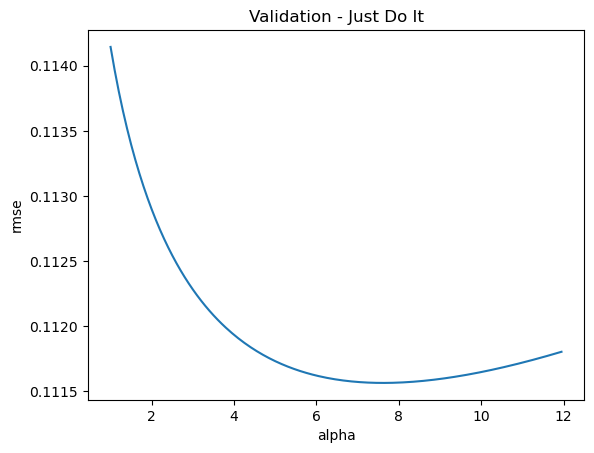

In [16]:
alphas = np.arange(1, 12, 0.05)
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean()
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title="Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [17]:
print("min rmse", cv_ridge.min())
cv_ridge[cv_ridge == cv_ridge.min()]

min rmse 0.11156304822962346


7.6    0.111563
dtype: float64

In [18]:
ridge = Ridge(alpha = cv_ridge.min())
ridge.fit(X_train_processed, y_train_processed)

# testing the model on the test data
y_pred_lasso = ridge.predict(X_test_processed)
rmse(y_test_processed, y_pred_lasso)

0.13399745784512349

In [19]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005])
model_lasso.fit(X_train_processed, y_train_processed)
rmse_cv(model_lasso).mean()

0.11102524698116142

In [20]:
# # testing the model on the test data
y_pred_lasso = model_lasso.predict(X_test_processed)
rmse(y_test_processed, y_pred_lasso)

0.1345711704245069

In [21]:
coef = pd.Series(model_lasso.coef_, index = X_train_processed.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 129 variables and eliminated the other 206 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

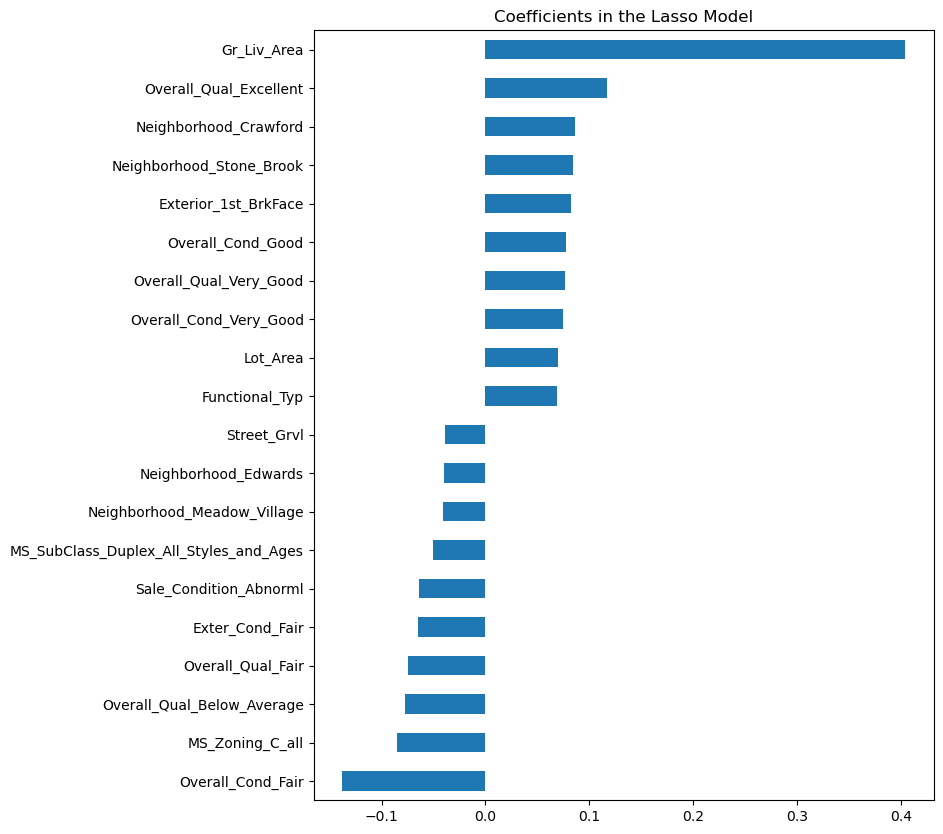

In [22]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

<Axes: xlabel='preds', ylabel='residuals'>

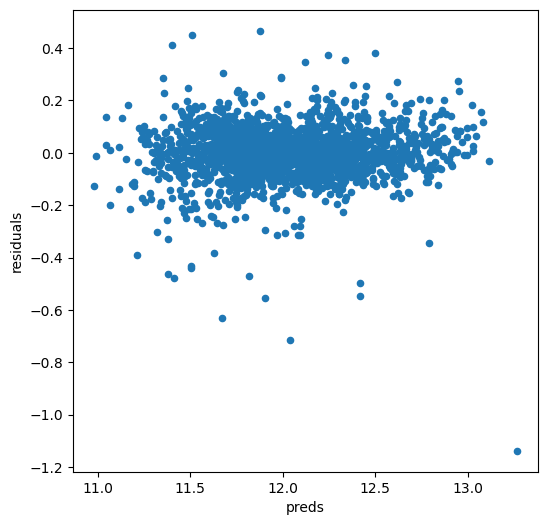

In [23]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train_processed), "true":y_train_processed})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

<Axes: >

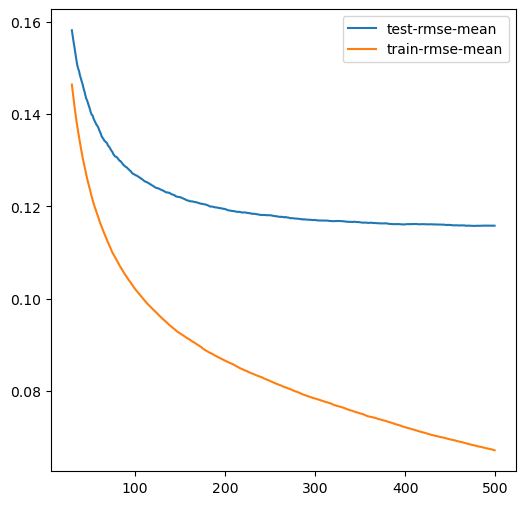

In [24]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_processed, label = y_train_processed)
dtest = xgb.DMatrix(X_test_processed)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [25]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train_processed, y_train_processed)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=360, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [26]:
xgb_preds = model_xgb.predict(X_test_processed)
lasso_preds = model_lasso.predict(X_test_processed)

# rmse of the xgb and lasso models
print(rmse(y_test_processed, xgb_preds))
print(rmse(y_test_processed, lasso_preds))

0.11334952831167669
0.1345711704245069


<Axes: xlabel='xgb', ylabel='lasso'>

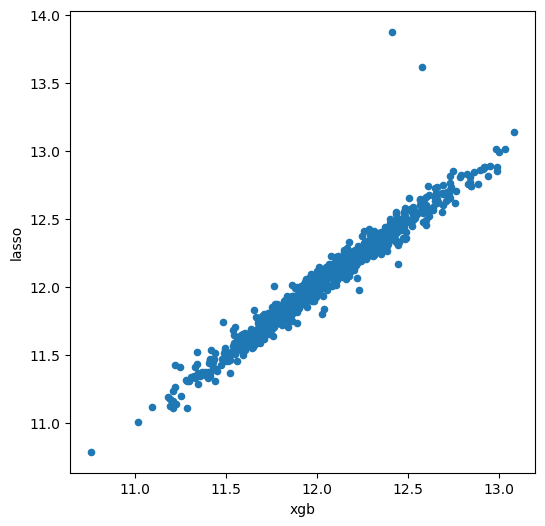

In [27]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [28]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [29]:
print(rmse(y_test_processed, preds))

0.12251071758069017
